# Import

In [1]:
import rdkit
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw, Lipinski
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor, rdMolDescriptors, rdFMCS, AllChem
from rdkit.Chem.MolStandardize import rdMolStandardize

from tqdm import tqdm
from rdkit.ML.Cluster.Butina import ClusterData
from rdkit.DataManip.Metric import GetTanimotoDistMat
from rdkit.SimDivFilters.rdSimDivPickers import HierarchicalClusterPicker, ClusterMethod


from IPython.core.display import display, HTML, Math

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import mols2grid

import time
rdDepictor.SetPreferCoordGen(True)

%pylab inline
print(rdkit.__version__)

cmap = plt.get_cmap("tab10")


INFO:rdkit:Enabling RDKit 2020.09.1 jupyter extensions


Populating the interactive namespace from numpy and matplotlib
2020.09.1


Cluster 10k molecules instead of 50k

In [3]:
df_clustered_10k = pd.read_csv(
    '/home/wjm41/ml_physics/frag-pcore-screen/data/EnamineREAL/topN/mpro_test_10k.csv')

df_clustered_10k['mol'] = df_clustered_10k['smiles'].apply(Chem.MolFromSmiles)
test_10k_grid = mols2grid.display(df_clustered_10k, template="pages", smiles_col='smiles', mol_col='mol',
                                  n_rows=15, n_cols=4, subset=["img", "membership", 'smiles'], transform={"membership": lambda x: f"Cluster #: {x}"},
                                  tooltip=['smiles'],
                                  maxMols=60, size=(300, 150), selection=True)

display(HTML('<b>Mpro 10k Butina</b>'))
display(test_10k_grid)


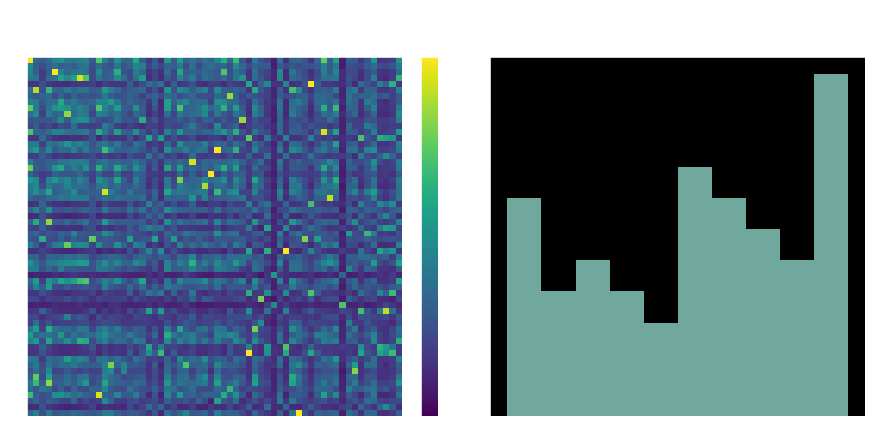

In [13]:
df_mpro = pd.read_csv(
    '/home/wjm41/ml_physics/frag-pcore-screen/data/EnamineREAL/topN/mpro_taut_picks_constrained_new.csv')

df_clustered_10k['fps'] = [rdMolDescriptors.GetMorganFingerprintAsBitVect(
    Chem.MolFromSmiles(smi), 2, 2048, useFeatures=True) for smi in df_clustered_10k["smiles"]]  # pharmacophore fingerprint
df_mpro['fps'] = [rdMolDescriptors.GetMorganFingerprintAsBitVect(
    Chem.MolFromSmiles(smi), 2, 2048, useFeatures=True) for smi in df_mpro["smiles"]]  # pharmacophore fingerprint

sim_mat = np.empty((len(df_clustered_10k), len(df_mpro)))
for i in range(len(df_clustered_10k)):
    sim_mat[i] = np.array(
        DataStructs.BulkTanimotoSimilarity(df_clustered_10k['fps'].values[i], df_mpro['fps'].values))

fig, axs = plt.subplots(figsize=(12, 6), ncols=2, constrained_layout=True)
fig.suptitle('df_clustered_10k vs df_mpro')
axs[0].set_title('Max similarity: {:.3f}\n Median similarity: {:.3f}'.format(
    np.amax(sim_mat),
    np.median(sim_mat)))
cax = axs[0].matshow(sim_mat, aspect="auto", vmin=0, vmax=1)
axs[0].xaxis.set_ticks_position('bottom')
fig.colorbar(cax, ax=axs[0])
# plt.show()

max_sim = []
for row in sim_mat:
    max_sim.append(np.amax(row))
    
axs[1].set_title('Max Tanimoto Similarity Histogram')
axs[1].hist(max_sim, label='df_clustered_10k vs df_mpro',
            alpha=0.8)  # only choose the lower triangle

# plt.legend(loc='upper right')
plt.show()
